In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from joblib import Parallel, delayed
import multiprocessing

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
'''
1 少量宏观数据与大类资产
'''

'\n1 少量宏观数据与大类资产\n'

In [2]:
MacroList = ['PMI', 'CPI:当月同比', 'PPI:全部工业品:当月同比', '工业增加值:当月同比', 'M2:同比','长短期利差', '信用利差']
AssetList = ['沪深300','南华商品指数','中证全债','货币基金']

In [122]:
MacroData = pd.read_excel('C:/Users/Thinkpad/Desktop/原电脑桌面/宏观经济指标数据.xlsx').set_index('date')
MacroData['长短期利差'] = MacroData['中债国债到期收益率:10年'] - MacroData['中债国债到期收益率:1年']
MacroData['信用利差'] = MacroData['中债企业债到期收益率(AA):1年'] - MacroData['中债企业债到期收益率(AAA):1年']
MacroData_ = MacroData[MacroList].copy()
MacroData_M = MacroData_.apply(lambda x:x.resample("M").last())
MacroData_M_Lag1 = MacroData_M.copy()
for col in ['PMI', 'CPI:当月同比', 'PPI:全部工业品:当月同比', '工业增加值:当月同比', 'M2:同比']:
    MacroData_M_Lag1[col] = MacroData_M[col].shift(1)
MacroData_M_Lag1 = MacroData_M_Lag1.dropna()

In [4]:
Asset = pd.read_excel('C:/Users/Thinkpad/Desktop/原电脑桌面/大类资产数据.xlsx').set_index('date')
AssetReturn = Asset.pct_change().dropna()
Asset_M = Asset.apply(lambda x:x.resample("M").last())
AssetReturn_M = Asset_M.pct_change().dropna()

In [5]:
MacroData_M_Lag1_Return = MacroData_M_Lag1.merge(AssetReturn_M,left_index=True,right_index=True,how='left')
for col in AssetList:
    MacroData_M_Lag1_Return[col] = MacroData_M_Lag1_Return[col].shift(-1)
MacroData_M_Lag1_Return = MacroData_M_Lag1_Return.dropna()

In [ ]:
'''
1.1 少量宏观数据与大类资产 - 原始指标与下期收益相关系数
'''

In [6]:
# 原指标预测相关系数
SaveDict = {}
for MacroIndicator in MacroList:
    SaveList = []
    for AssetClass in AssetList:
        SaveList.append(np.corrcoef(MacroData_M_Lag1_Return[MacroIndicator],MacroData_M_Lag1_Return[AssetClass])[1,0])
    SaveDict[MacroIndicator] = SaveList
pd.DataFrame(SaveDict,index=AssetList)

,PMI,CPI:当月同比,PPI:全部工业品:当月同比,工业增加值:当月同比,M2:同比,长短期利差,信用利差
沪深300,-0.173855,-0.279751,-0.208295,-0.136846,0.000515,0.055816,-0.007631
南华商品指数,-0.003180,-0.189170,-0.203593,-0.150285,0.059568,0.135409,-0.024489
中证全债,-0.109018,0.136284,0.136347,0.004314,-0.086324,-0.122903,0.145096
货币基金,-0.091530,0.308664,0.186871,-0.079917,-0.513994,-0.627501,0.096920


In [ ]:
'''
1.2 少量宏观数据与大类资产 - 衍生指标与下期收益相关系数
'''

In [7]:
# 衍生指标
IndicatorList = ['ma2','ma3','pct','ma3_pct']
DfSaveDict = {}
for MacroIndicator in MacroList:
    SaveDict = {}
    
    # 计算衍生指标
    MacroData_M_Lag1_Return_tmp = MacroData_M_Lag1_Return.copy()
    MacroData_M_Lag1_Return_tmp['ma2'] = MacroData_M_Lag1_Return_tmp[MacroIndicator].rolling(2).mean()
    MacroData_M_Lag1_Return_tmp['ma3'] = MacroData_M_Lag1_Return_tmp[MacroIndicator].rolling(3).mean()
    MacroData_M_Lag1_Return_tmp['pct'] = MacroData_M_Lag1_Return_tmp[MacroIndicator].pct_change()
    MacroData_M_Lag1_Return_tmp['ma3_pct'] = MacroData_M_Lag1_Return_tmp['ma3'].pct_change()
    
    MacroData_M_Lag1_Return_tmp = MacroData_M_Lag1_Return_tmp.dropna().copy()
    # 循环计算衍生指标
    for Indicator in IndicatorList+[MacroIndicator]:
        SaveList = []
        for AssetClass in AssetList:
            SaveList.append(np.corrcoef(MacroData_M_Lag1_Return_tmp[Indicator],MacroData_M_Lag1_Return_tmp[AssetClass])[1,0])
        SaveDict[Indicator] = SaveList
    IndicatorCorrDf = pd.DataFrame(SaveDict,index=AssetList).T
    DfSaveDict[MacroIndicator] = IndicatorCorrDf
    print(MacroIndicator)
    print(IndicatorCorrDf)
    print()

PMI
            沪深300    南华商品指数      中证全债      货币基金
ma2     -0.234060 -0.026279 -0.043870 -0.051740
ma3     -0.261769 -0.082238 -0.024145 -0.032564
pct      0.010199  0.075731 -0.114851 -0.099763
ma3_pct  0.043294  0.166263 -0.170185 -0.158553
PMI     -0.224046 -0.001753 -0.077538 -0.076938

CPI:当月同比
             沪深300    南华商品指数      中证全债      货币基金
ma2      -0.304076 -0.208368  0.152612  0.324741
ma3      -0.298200 -0.220902  0.169828  0.328437
pct      -0.014084  0.073034  0.047970  0.104378
ma3_pct  -0.055697 -0.052450 -0.084304  0.197937
CPI:当月同比 -0.307094 -0.192914  0.139826  0.315288

PPI:全部工业品:当月同比
                   沪深300    南华商品指数      中证全债      货币基金
ma2            -0.201854 -0.197442  0.140702  0.207160
ma3            -0.176056 -0.184330  0.130729  0.219246
pct            -0.066949  0.058327 -0.201663 -0.092464
ma3_pct         0.004479  0.085984 -0.036338 -0.076900
PPI:全部工业品:当月同比 -0.224349 -0.205516  0.143025  0.190853

工业增加值:当月同比
               沪深300    南华商品指数      中证全债      

In [ ]:
'''
1.2 少量宏观数据与大类资产 - 衍生指标相关系数
'''

In [8]:
# 每个衍生指标corr绝对值最大情况
AbsMaxDf = pd.DataFrame()
for key in DfSaveDict.keys():
    
    DfSave = DfSaveDict[key].copy()
    AbsMaxDfKey = pd.DataFrame(columns=DfSave.columns,index=[key+' Event','Corr'])
    DfSave_Abs = DfSave.apply(lambda x: np.abs(x))
    for col in DfSave_Abs.columns:
        argmaxN = np.argmax(DfSave_Abs[col].tolist())
        AbsMaxDfKey.loc[key+' Event',col] = DfSave_Abs.index[argmaxN]
        AbsMaxDfKey.loc['Corr',col] = DfSave[col].tolist()[argmaxN]
    AbsMaxDf = pd.concat([AbsMaxDf,AbsMaxDfKey],axis=0)
AbsMaxDf

,沪深300,南华商品指数,中证全债,货币基金
PMI Event,ma3,ma3_pct,ma3_pct,ma3_pct
Corr,-0.261769,0.166263,-0.170185,-0.158553
CPI:当月同比 Event,CPI:当月同比,ma3,ma3,ma3
Corr,-0.307094,-0.220902,0.169828,0.328437
PPI:全部工业品:当月同比 Event,PPI:全部工业品:当月同比,PPI:全部工业品:当月同比,pct,ma3
Corr,-0.224349,-0.205516,-0.201663,0.219246
工业增加值:当月同比 Event,ma2,ma2,ma3,ma3_pct
Corr,-0.229564,-0.17359,0.0968751,-0.106475
M2:同比 Event,ma3_pct,ma3_pct,ma3_pct,M2:同比
Corr,0.132829,0.0947272,-0.199333,-0.512806


In [9]:
'''
1.2 少量宏观数据与大类资产 - 衍生指标 x 事件 发生后的下期收益平均值/中位数
'''

'\n1.2 少量宏观数据与大类资产 - 衍生指标 x 事件 发生后的下期收益平均值/中位数\n'

In [10]:
# 衍生指标 x 事件 - 构造，T-1，T-2，T-3，T-4
def EventCompute(series):
    cut1 = series[-3]-series[-4]
    cut2 = series[-2]-series[-3]
    cut3 = series[-1]-series[-2]
    if event1 == 1:
        cut1bool = cut1 >=0
    else:
        cut1bool = cut1 <0
    if event2 == 1:
        cut2bool = cut2 >=0
    else:
        cut2bool = cut2 <0
    if event3 == 1:
        cut3bool = cut3 >=0
    else:
        cut3bool = cut3 <0
    if cut1bool & cut2bool & cut3bool:
        return 1
    else:
        return 0
MacroData_M_Lag1_Return_test = MacroData_M_Lag1_Return[MacroList].copy()
MacroData_M_Lag1_Return_test_save = pd.DataFrame(index=MacroData_M_Lag1_Return_test.index)
for col in MacroData_M_Lag1_Return_test.columns:
    for event1 in [0,1]:
        for event2 in [0,1]:
            for event3 in [0,1]:
                MacroData_M_Lag1_Return_test_save[str(event1)+str(event2)+str(event3)+col] = MacroData_M_Lag1_Return_test[col].rolling(4).apply(EventCompute,raw=False)    

In [11]:
(MacroData_M_Lag1_Return_test_save.sum()/len(MacroData_M_Lag1_Return_test_save)*100).to_frame('EventHappenFreq %')

,EventHappenFreq %
000PMI,9.589041
001PMI,13.698630
010PMI,9.589041
011PMI,12.328767
100PMI,13.698630
101PMI,8.219178
110PMI,12.328767
111PMI,18.493151
000CPI:当月同比,15.753425
001CPI:当月同比,7.534247


In [12]:
# 衍生指标 x 事件 - 下期收益率均值
AssetList = ['沪深300','南华商品指数','中证全债','货币基金']
cols = MacroData_M_Lag1_Return_test_save.columns
AnalysisEventReturnDf = pd.concat([MacroData_M_Lag1_Return_test_save,MacroData_M_Lag1_Return],axis=1)
AnalysisEventReturnDict = {}
for asset in AssetList:
    AnalysisEventReturnList = []
    for col in cols:
        AnalysisEventReturnList.append(AnalysisEventReturnDf[AnalysisEventReturnDf[col]==1][asset].median())
    AnalysisEventReturnDict[asset] = AnalysisEventReturnList

In [13]:
AnalysisEventReturnResult = pd.DataFrame(AnalysisEventReturnDict,index=cols)*12

In [14]:
AnalysisEventReturnResult

,沪深300,南华商品指数,中证全债,货币基金
000PMI,0.101468,0.049135,0.033065,0.035221
001PMI,0.188488,-0.016793,0.046160,0.033208
010PMI,0.133643,0.202146,0.074258,0.030477
011PMI,0.116756,-0.077811,0.016989,0.037543
100PMI,-0.229262,-0.078709,0.061023,0.029934
101PMI,0.106540,0.047982,0.039023,0.040083
110PMI,0.065856,-0.047782,0.054443,0.035715
111PMI,0.026891,-0.026665,0.051454,0.030528
000CPI:当月同比,0.306126,0.129225,0.062982,0.040343
001CPI:当月同比,0.022805,0.194564,0.060827,0.036671


In [ ]:
'''
2 大类资产间相关性
'''

In [ ]:
'''
2.1 大类资产间相关性 - 滚动相关系数
'''

In [ ]:
window = 63
AssetsCorrDf = pd.DataFrame(index = AssetReturn.index)
for comb in list(map(list,itertools.combinations(AssetList, 2))):
    col1 = comb[0]
    col2 = comb[1]
    AssetsCorrDf[col1+' '+col2] = AssetReturn[col1].rolling(window).corr(AssetReturn[col2])

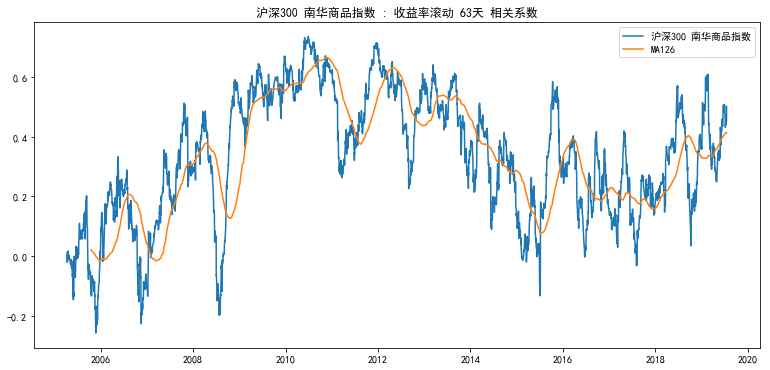

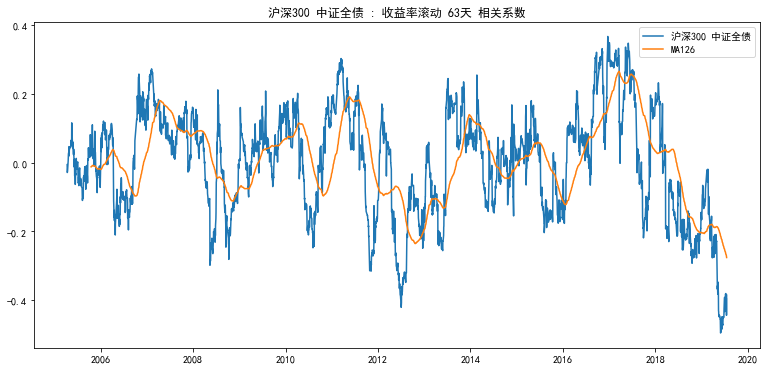

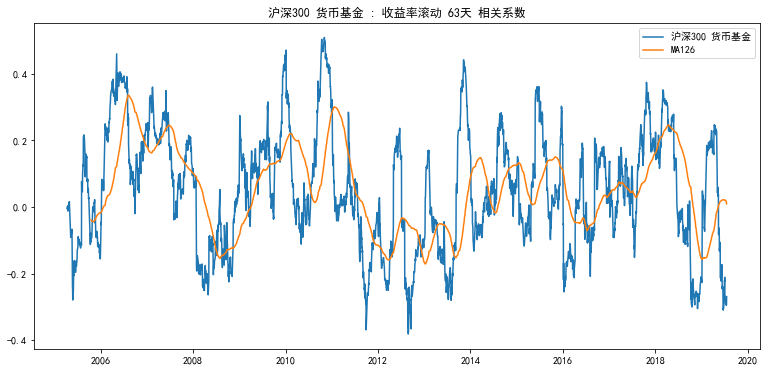

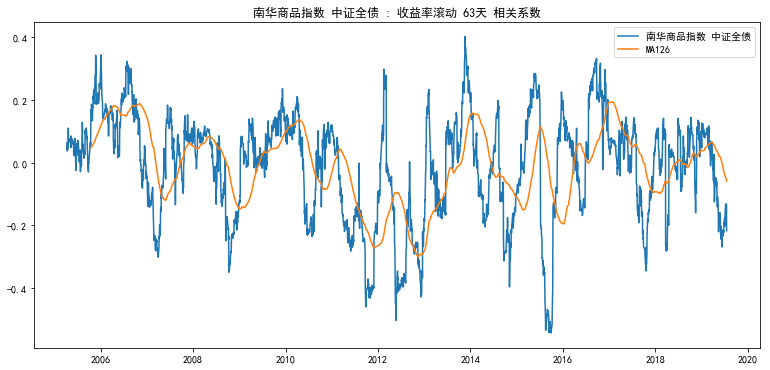

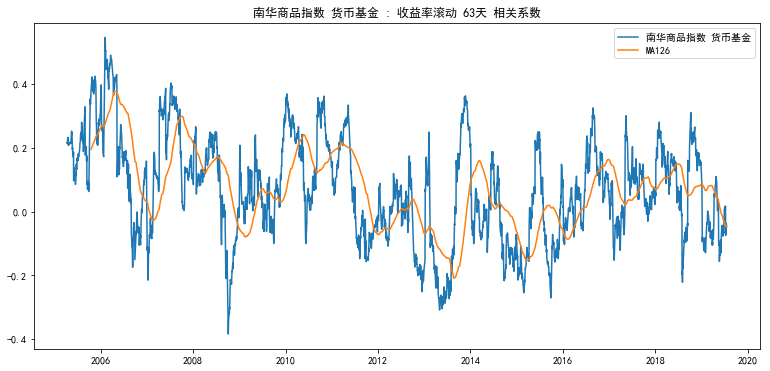

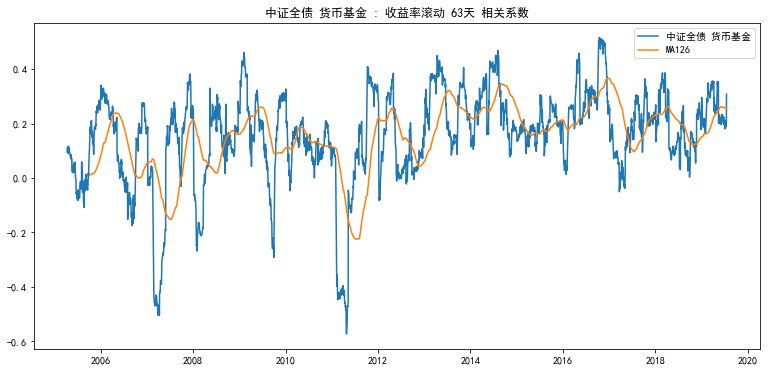

In [94]:
window1 = 126
for col in AssetsCorrDf.columns:
    plt.figure(figsize=(13,6))
    plt.plot(AssetsCorrDf[col],label=col)
    plt.plot(AssetsCorrDf[col].rolling(window1).mean(),label='MA'+str(window1))
    plt.title(col+' : 收益率滚动 '+str(window)+'天 相关系数')
    plt.legend(loc=0)
    plt.show()

In [ ]:
'''
2.2 大类资产间相关性 - 截面收益与截面波动（历史N天收益计算）的秩相关系数
'''

In [212]:
RankWind = 42
AssetReturnMean = AssetReturn.rolling(RankWind).mean()
AssetReturnStd = AssetReturn.rolling(RankWind).std()

In [213]:
def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.concat(retLst)

def ComputeRank(df):
    df = df.copy()
    trade_date = df['date'].tolist()[0]
    dfSub = df[AssetList]
    tmpDf = dfSub.T
    tmpcol = tmpDf.columns.tolist()[0]
    tmpDf0 = tmpDf.sort_values(tmpcol,ascending=False)
    tmpDf0[tmpcol] = range(1,len(tmpDf)+1)
    tmpDf1 = tmpDf0.T[AssetList]
    tmpDf1.index = [trade_date]
    return tmpDf1

AssetReturnStdRank = applyParallel(AssetReturnStd.reset_index().groupby('date'),ComputeRank)
AssetReturnMeanRank = applyParallel(AssetReturnMean.reset_index().groupby('date'),ComputeRank)

In [214]:
IterList = []
DateList = AssetReturnMeanRank.index
for date in AssetReturnMeanRank.index:
    MeanRankList = AssetReturnMeanRank.loc[date,:].tolist()
    StdRankList = AssetReturnStdRank.loc[date,:].tolist()
    IterList.append([MeanRankList,StdRankList])

def ComputeCorr(List):
    return np.corrcoef(List[0],List[1])[0,1]
    
RankCorrList = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(ComputeCorr)(group) for group in IterList)

In [215]:
RankCorrDf = pd.DataFrame(RankCorrList,index=DateList,columns=['RankCorr'])

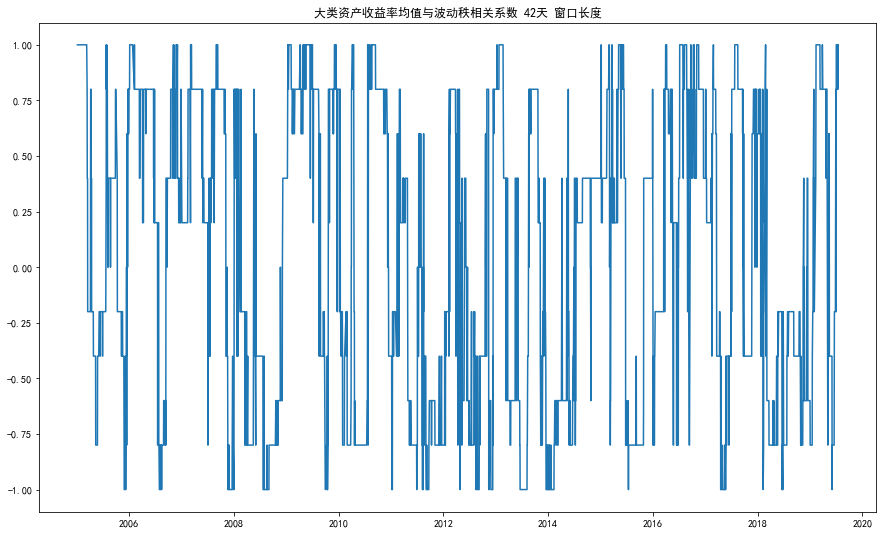

In [216]:
plt.figure(figsize=(15,9))
plt.title('大类资产收益率均值与波动秩相关系数 '+str(RankWind)+'天 窗口长度')
plt.plot(RankCorrDf)
plt.show()

In [228]:
AssetReturn_tmp = AssetReturn.copy()
AssetReturn_tmp['Signal'] = RankCorrDf.shift(1)

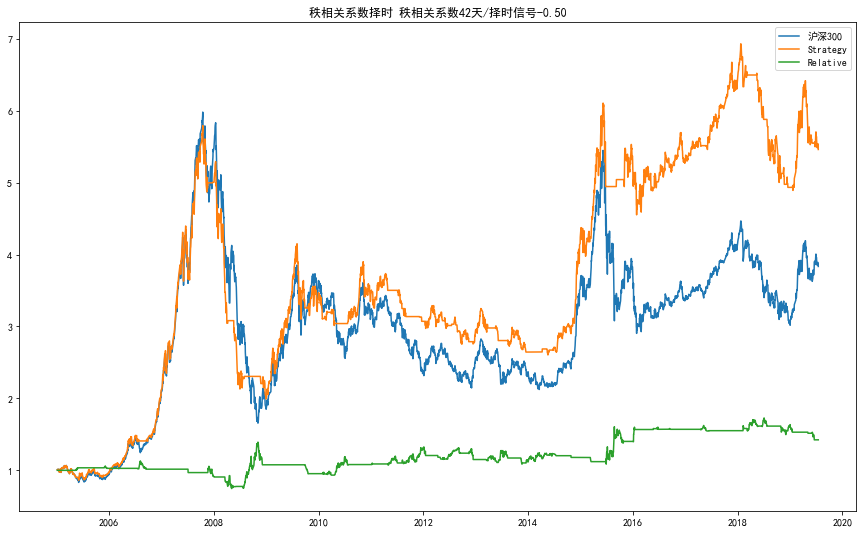

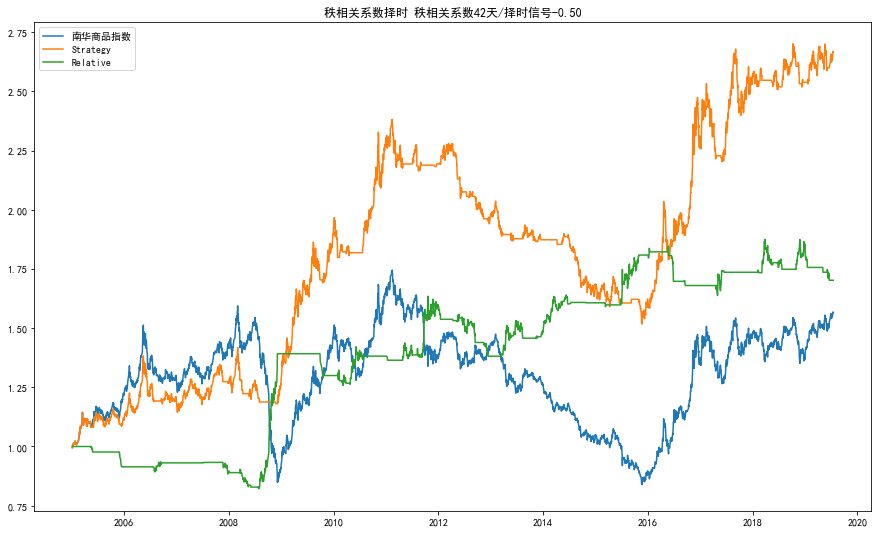

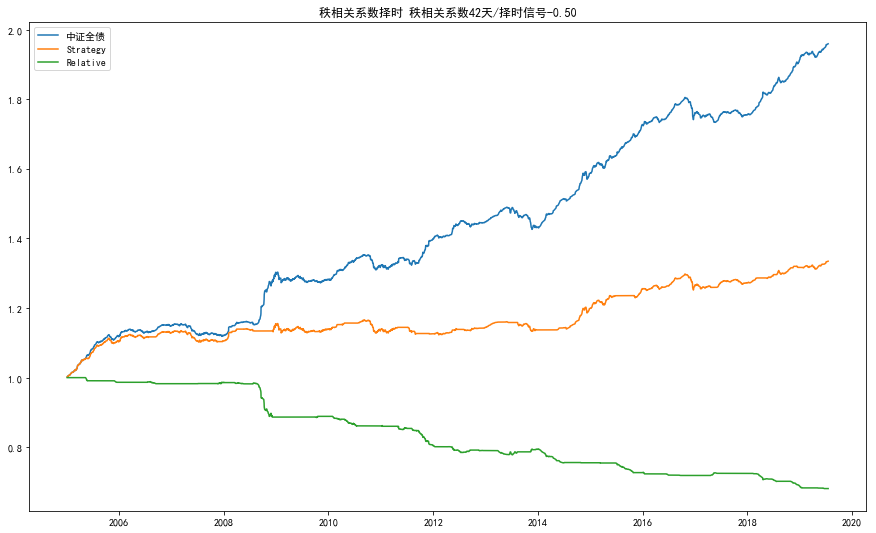

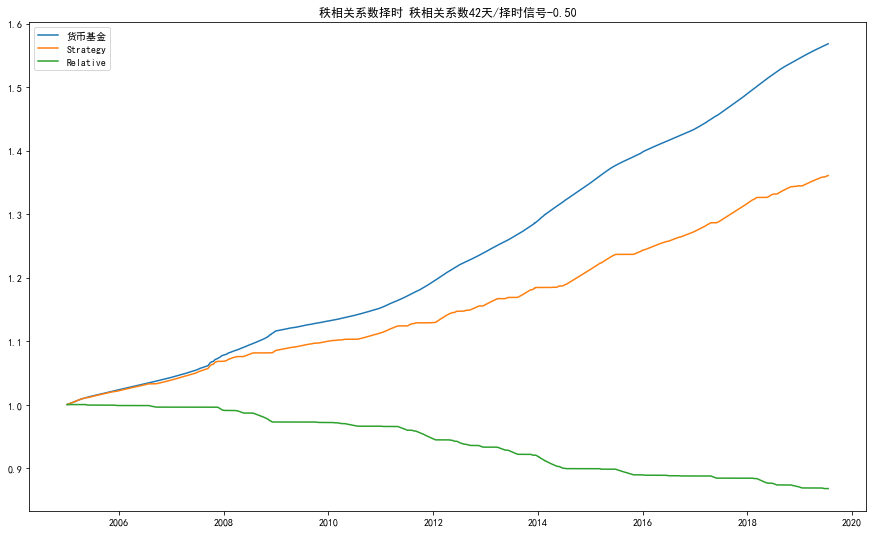

In [231]:
downline = -0.5
for asset in AssetList:
    AssetReturn_tmp['Strategy'] = AssetReturn_tmp.apply(lambda x: 0 if x['Signal']<downline else x[asset],axis=1)
    plt.figure(figsize=(15,9))
    plt.title('秩相关系数择时 秩相关系数%d天/择时信号%.2f' %(RankWind,downline))
    plt.plot((AssetReturn_tmp[asset]+1).cumprod(),label=asset)
    plt.plot((AssetReturn_tmp['Strategy']+1).cumprod(),label='Strategy')
    plt.plot((AssetReturn_tmp['Strategy']+1).cumprod()/(AssetReturn_tmp[asset]+1).cumprod(),label='Relative')
    plt.legend(loc=0)
    plt.show()

In [ ]:
'''
3 宏观指标均线 趋势与下期收益
'''

In [16]:
MacroData_M_Lag1_Return_Trend = MacroData_M_Lag1_Return.copy()

In [51]:
Macro_3M = ['PMI',  '工业增加值:当月同比', 'M2:同比','长短期利差', '信用利差']
Macro_9M = ['CPI:当月同比', 'PPI:全部工业品:当月同比']
TrendList = []
for col in Macro_3M:
    MacroData_M_Lag1_Return_Trend[col+' ma3_pct'] = (MacroData_M_Lag1_Return_Trend[col].rolling(3).mean()).pct_change()
    MacroData_M_Lag1_Return_Trend[col+' ma3up'] = MacroData_M_Lag1_Return_Trend[col+' ma3_pct'].apply(lambda x: 1 if x>=0 else 0)
    MacroData_M_Lag1_Return_Trend[col+' ma3down'] = MacroData_M_Lag1_Return_Trend[col+' ma3_pct'].apply(lambda x: 1 if x<0 else 0)
    TrendList.append(col+' ma3up')
    TrendList.append(col+' ma3down')
for col in Macro_9M:
    MacroData_M_Lag1_Return_Trend[col+' ma9_pct'] = (MacroData_M_Lag1_Return_Trend[col].rolling(9).mean()).pct_change()
    MacroData_M_Lag1_Return_Trend[col+' ma9up'] = MacroData_M_Lag1_Return_Trend[col+' ma9_pct'].apply(lambda x: 1 if x>=0 else 0)
    MacroData_M_Lag1_Return_Trend[col+' ma9down'] = MacroData_M_Lag1_Return_Trend[col+' ma9_pct'].apply(lambda x: 1 if x<0 else 0)
    TrendList.append(col+' ma9up')
    TrendList.append(col+' ma9down')

In [53]:
MacroData_M_Lag1_Return_TrendForC = MacroData_M_Lag1_Return_Trend.dropna()

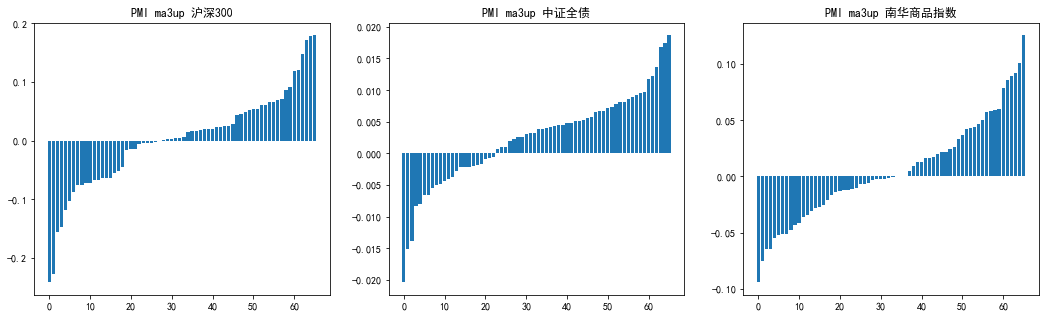

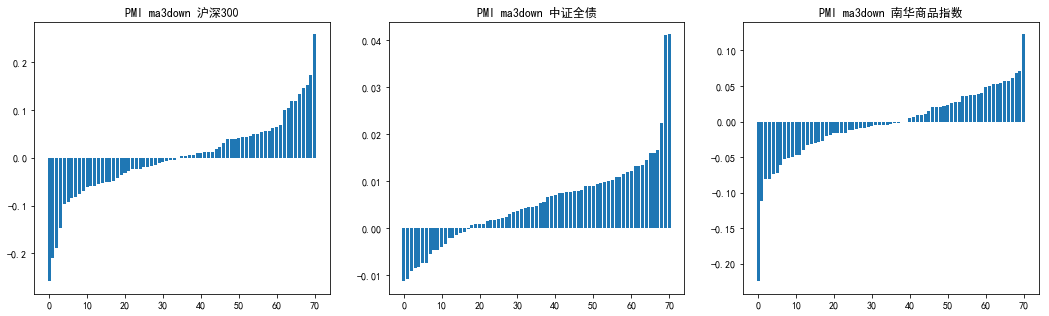

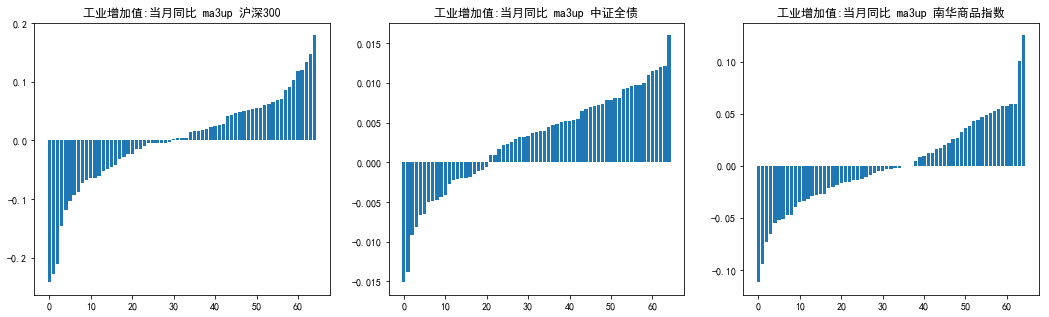

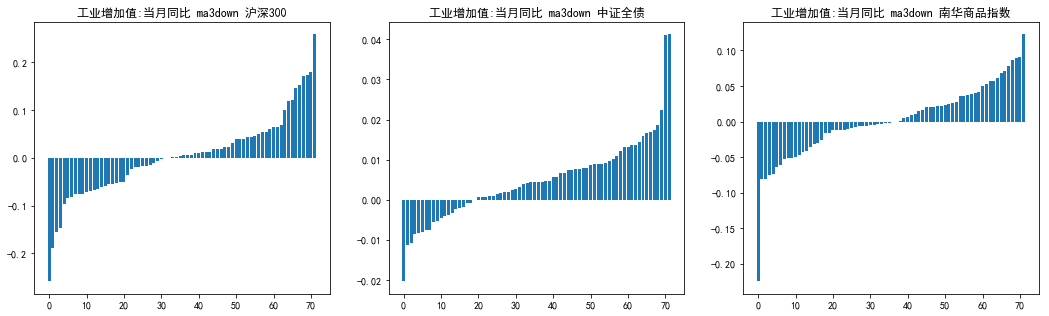

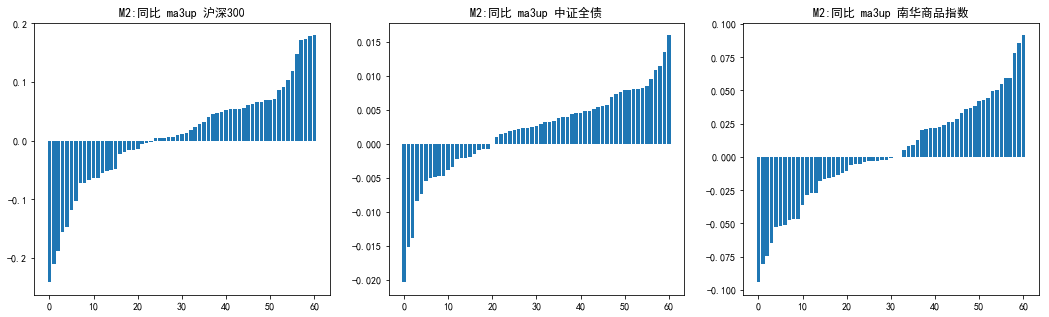

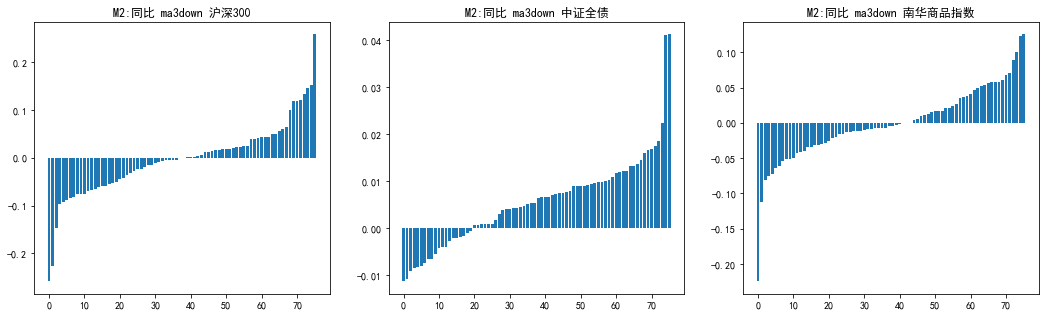

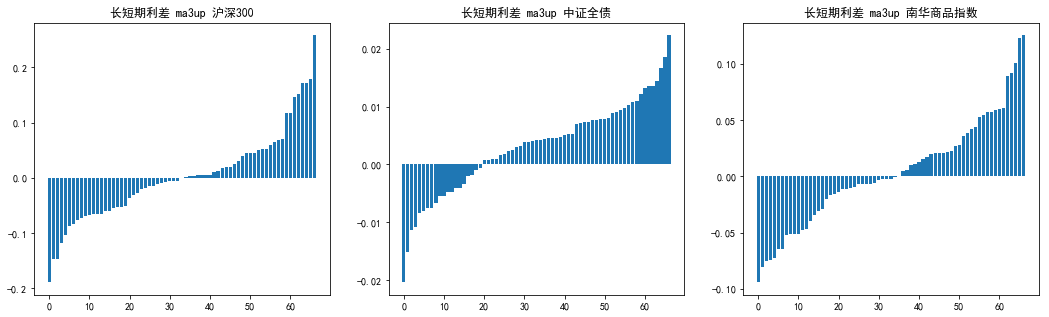

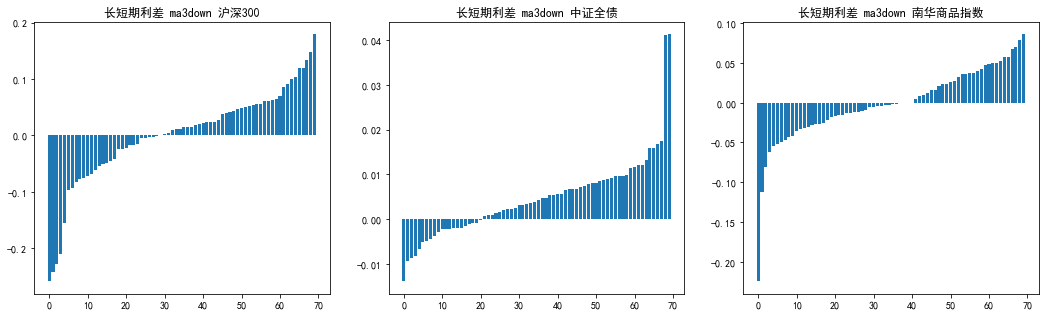

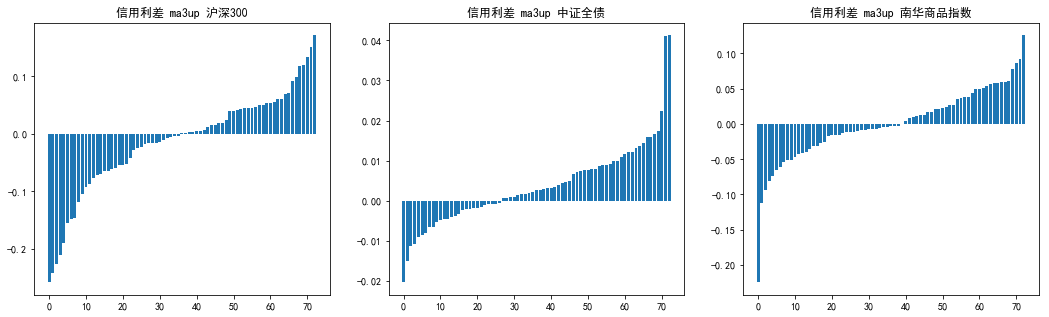

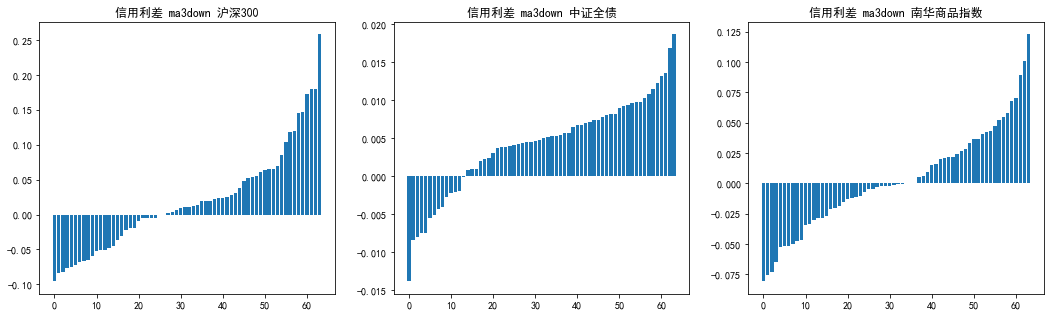

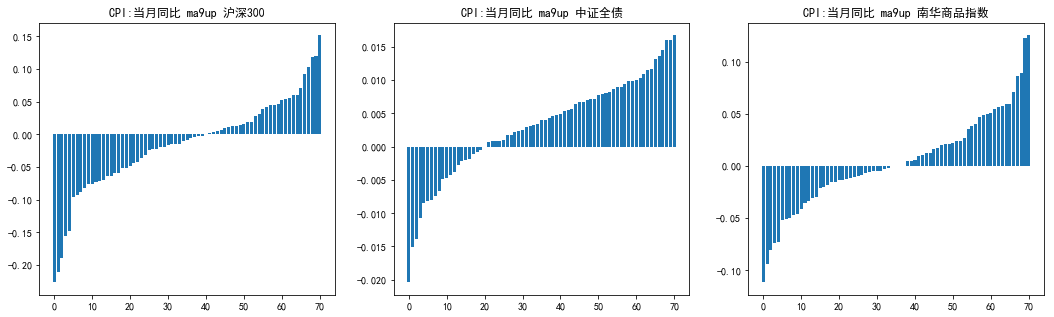

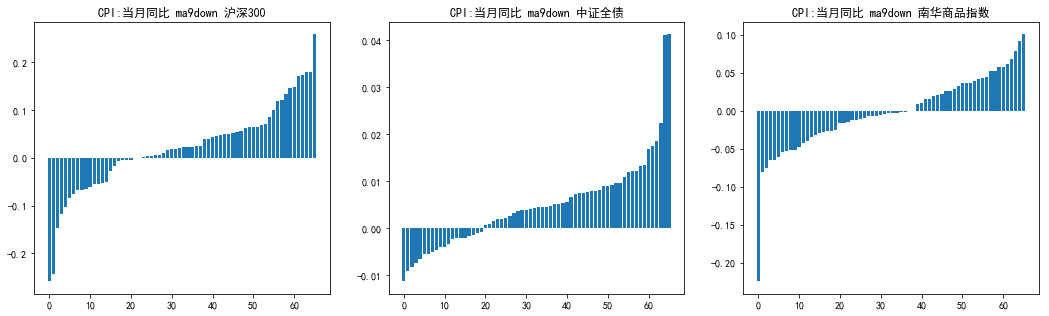

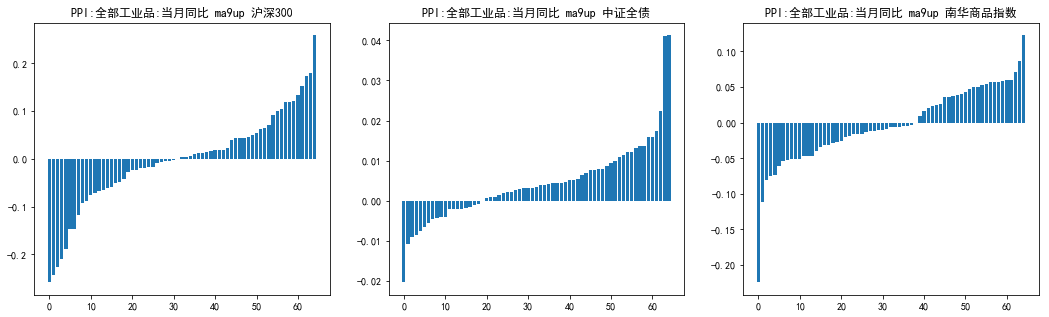

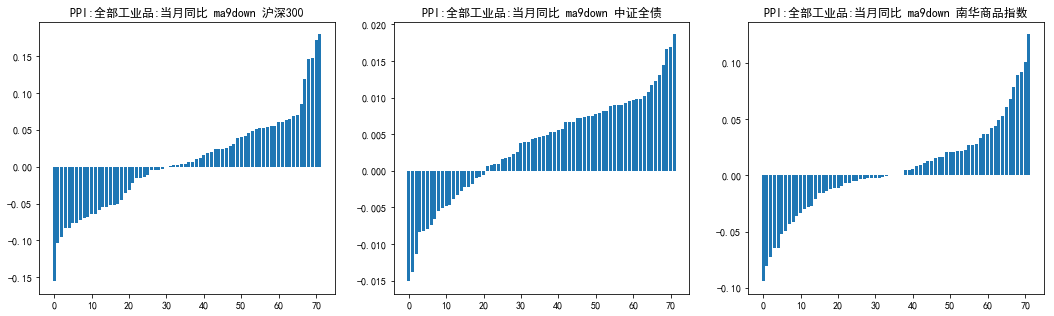

In [107]:
MacroData_M_Lag1_Return_TrendForC_Save = pd.DataFrame()
for col in TrendList:
    MacroData_M_Lag1_Return_TrendForC_sub = MacroData_M_Lag1_Return_TrendForC[MacroData_M_Lag1_Return_TrendForC[col] == 1]
    MacroData_M_Lag1_Return_TrendForC_sub_m = MacroData_M_Lag1_Return_TrendForC_sub[AssetList].mean().to_frame(col).T
    MacroData_M_Lag1_Return_TrendForC_Save = pd.concat([MacroData_M_Lag1_Return_TrendForC_Save,MacroData_M_Lag1_Return_TrendForC_sub_m],axis=0)
    
    # 绘制收益排序图，观察正负比重
    plt.figure(figsize=(18,5))
    for assetCnt in range(3):
        asset = ['沪深300','中证全债','南华商品指数'][assetCnt]
        plt.subplot(130+assetCnt+1)
        sub_return_sort = MacroData_M_Lag1_Return_TrendForC_sub[asset].sort_values().tolist()
        plt.title(col+' '+asset)
        plt.bar(x=range(len(sub_return_sort)),height=sub_return_sort)
    plt.show()

In [60]:
MacroData_M_Lag1_Return_TrendForC_Save

,沪深300,南华商品指数,中证全债,货币基金
PMI ma3up,0.001849,0.005082,0.002398,0.002618
PMI ma3down,0.002028,-0.002441,0.005371,0.002784
工业增加值:当月同比 ma3up,0.000490,0.000669,0.002860,0.002576
工业增加值:当月同比 ma3down,0.003253,0.001647,0.004913,0.002819
M2:同比 ma3up,0.008200,0.003015,0.001831,0.002440
M2:同比 ma3down,-0.003081,-0.000287,0.005631,0.002915
长短期利差 ma3up,0.002867,0.003504,0.003072,0.002691
长短期利差 ma3down,0.001056,-0.001038,0.004769,0.002716
信用利差 ma3up,-0.012941,-0.000255,0.003722,0.002768
信用利差 ma3down,0.018918,0.002824,0.004187,0.002630


In [ ]:
'''
4 宏观指标均线 趋势与当期收益
'''

In [71]:
MacroData_M_Lag1_Return_Trend_ = MacroData_M_Lag1_Return.copy()

In [72]:
for col in AssetList:
    MacroData_M_Lag1_Return_Trend_[col] = MacroData_M_Lag1_Return_Trend_[col].shift(1)

In [73]:
MacroData_M_Lag1_Return_Trend_ = MacroData_M_Lag1_Return_Trend_.dropna().copy()

In [74]:
Macro_3M = ['PMI',  '工业增加值:当月同比', 'M2:同比','长短期利差', '信用利差']
Macro_9M = ['CPI:当月同比', 'PPI:全部工业品:当月同比']
TrendList = []
for col in Macro_3M:
    MacroData_M_Lag1_Return_Trend_[col+' ma3_pct'] = (MacroData_M_Lag1_Return_Trend_[col].rolling(3).mean()).pct_change()
    MacroData_M_Lag1_Return_Trend_[col+' ma3up'] = MacroData_M_Lag1_Return_Trend_[col+' ma3_pct'].apply(lambda x: 1 if x>=0 else 0)
    MacroData_M_Lag1_Return_Trend_[col+' ma3down'] = MacroData_M_Lag1_Return_Trend_[col+' ma3_pct'].apply(lambda x: 1 if x<0 else 0)
    TrendList.append(col+' ma3up')
    TrendList.append(col+' ma3down')
for col in Macro_9M:
    MacroData_M_Lag1_Return_Trend_[col+' ma9_pct'] = (MacroData_M_Lag1_Return_Trend_[col].rolling(9).mean()).pct_change()
    MacroData_M_Lag1_Return_Trend_[col+' ma9up'] = MacroData_M_Lag1_Return_Trend_[col+' ma9_pct'].apply(lambda x: 1 if x>=0 else 0)
    MacroData_M_Lag1_Return_Trend_[col+' ma9down'] = MacroData_M_Lag1_Return_Trend_[col+' ma9_pct'].apply(lambda x: 1 if x<0 else 0)
    TrendList.append(col+' ma9up')
    TrendList.append(col+' ma9down')

In [75]:
MacroData_M_Lag1_Return_Trend_ForC = MacroData_M_Lag1_Return_Trend_.dropna()

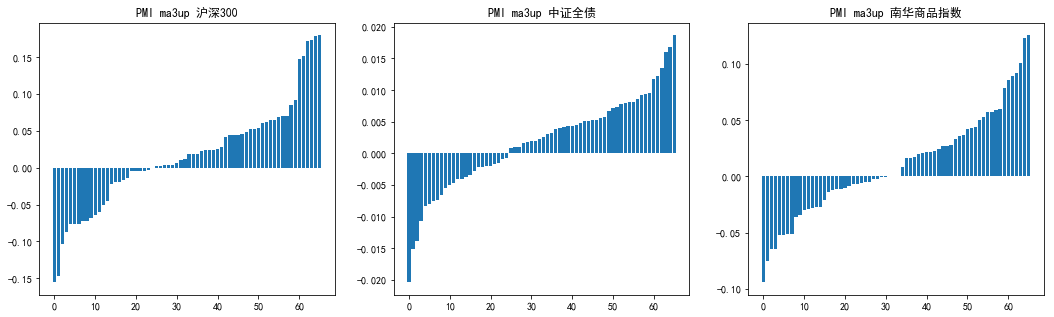

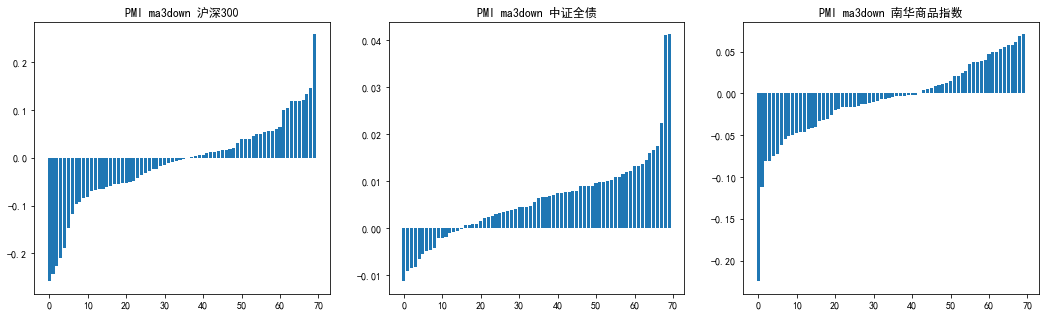

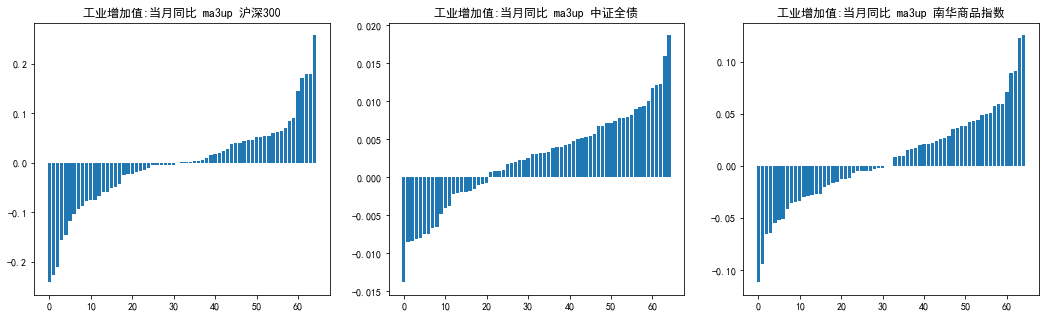

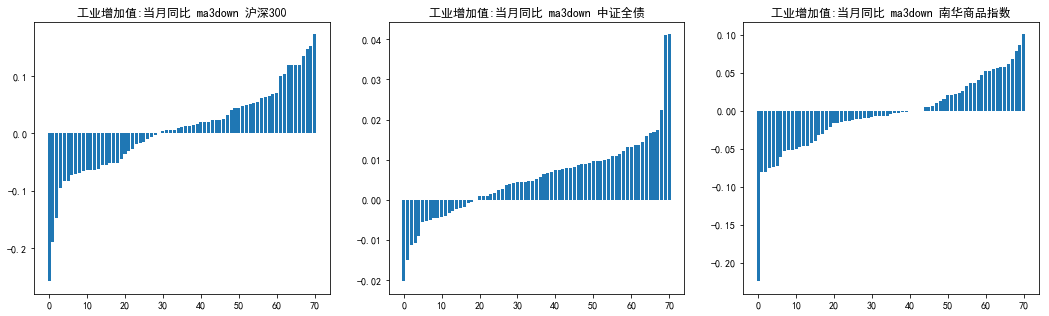

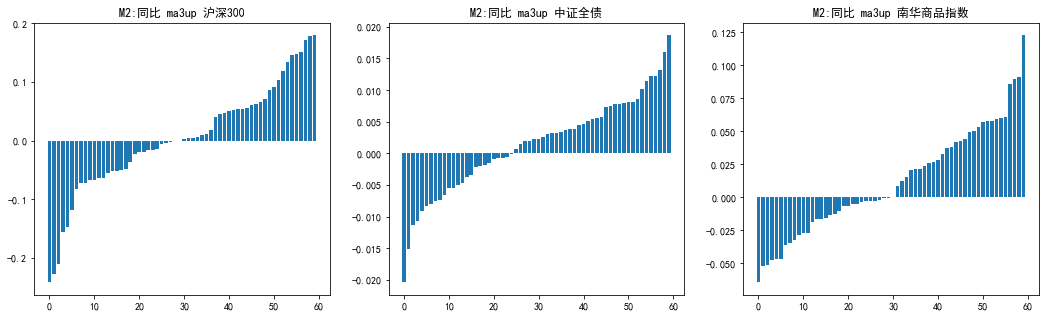

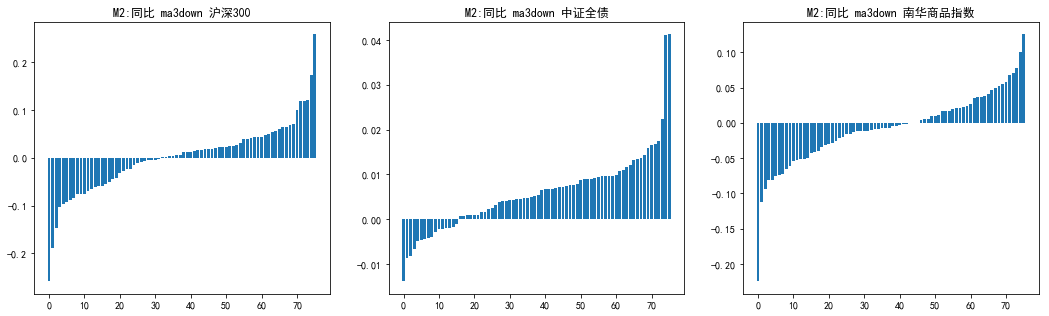

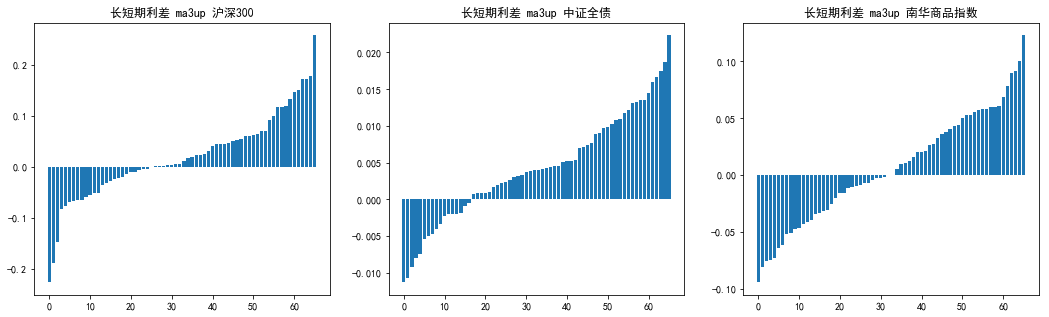

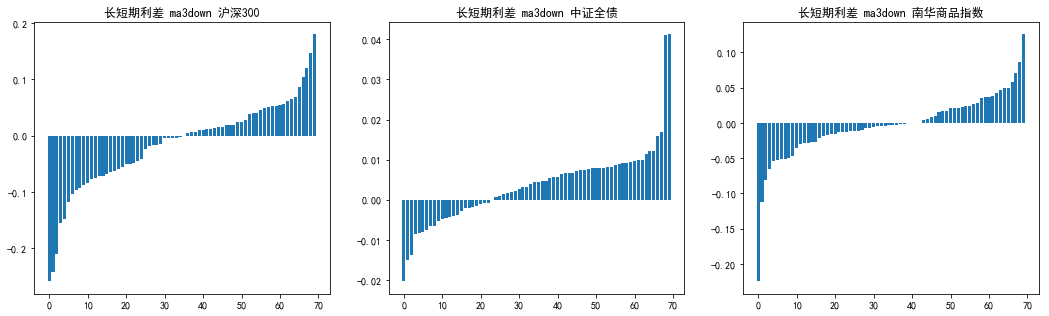

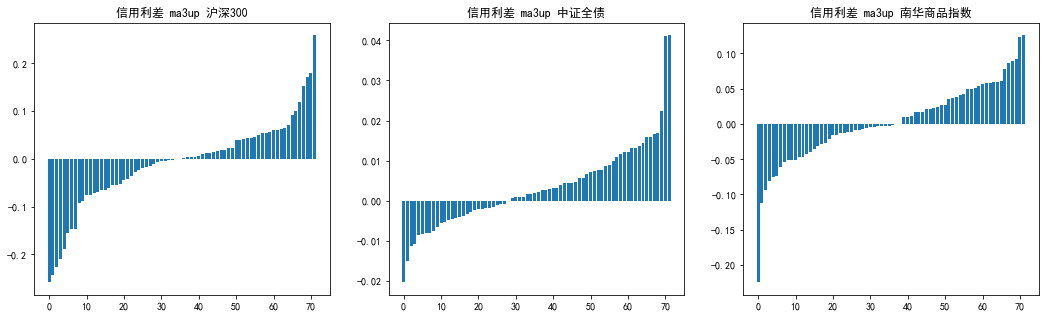

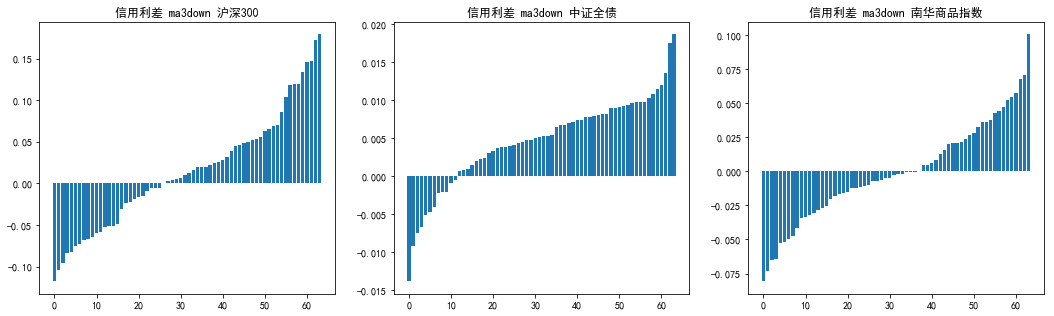

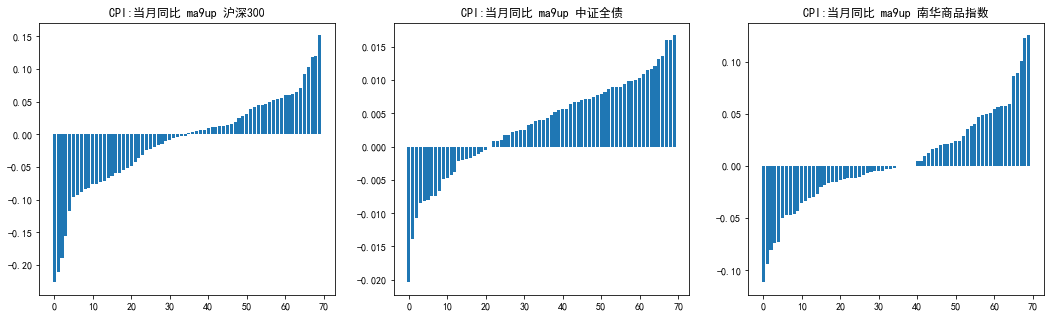

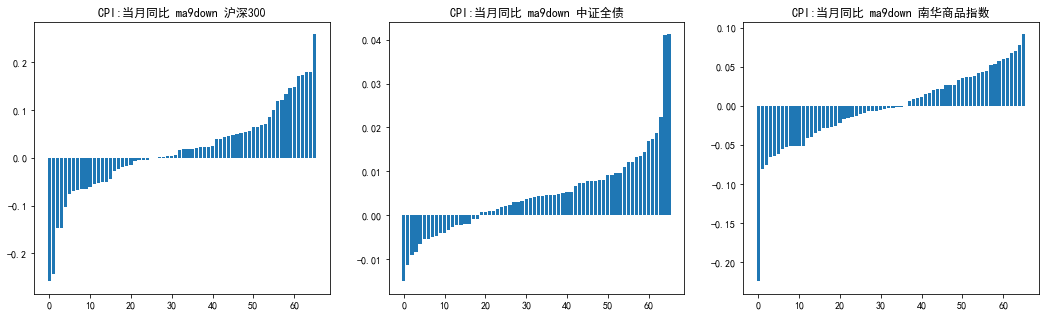

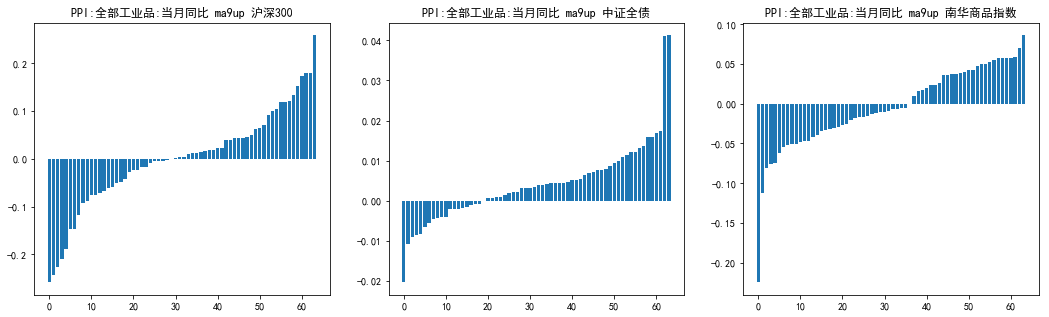

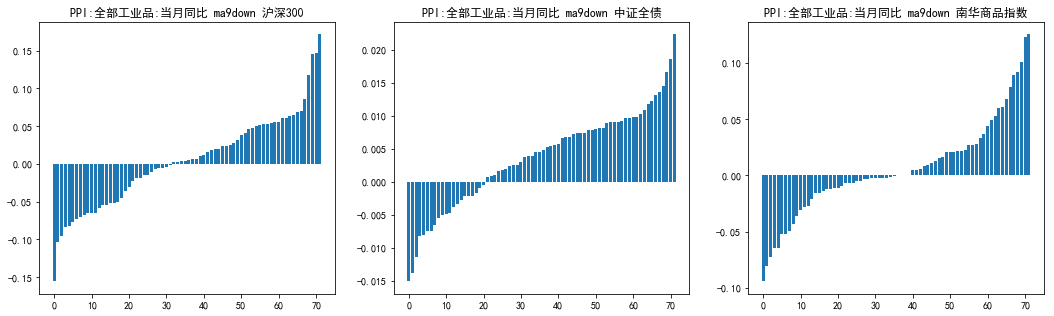

,沪深300,南华商品指数,中证全债,货币基金
PMI ma3up,0.015845,0.010489,0.001781,0.002591
PMI ma3down,-0.010926,-0.007756,0.005961,0.002831
工业增加值:当月同比 ma3up,-0.001934,0.006888,0.002407,0.002554
工业增加值:当月同比 ma3down,0.005728,-0.004202,0.005329,0.002861
M2:同比 ma3up,0.003467,0.011727,0.001376,0.002453
M2:同比 ma3down,0.000960,-0.007293,0.005951,0.002920
长短期利差 ma3up,0.019519,0.006029,0.004296,0.002810
长短期利差 ma3down,-0.014390,-0.003551,0.003590,0.002624
信用利差 ma3up,-0.008890,0.002391,0.003291,0.002767
信用利差 ma3down,0.014392,-0.000356,0.004654,0.002654


In [106]:
MacroData_M_Lag1_Return_Trend_ForC_Save = pd.DataFrame()
for col in TrendList:
    MacroData_M_Lag1_Return_Trend_ForC_sub = MacroData_M_Lag1_Return_Trend_ForC[MacroData_M_Lag1_Return_Trend_ForC[col] == 1]
    MacroData_M_Lag1_Return_Trend_ForC_sub_m = MacroData_M_Lag1_Return_Trend_ForC_sub[AssetList].mean().to_frame(col).T
    MacroData_M_Lag1_Return_Trend_ForC_Save = pd.concat([MacroData_M_Lag1_Return_Trend_ForC_Save,MacroData_M_Lag1_Return_Trend_ForC_sub_m],axis=0)

    # 绘制收益排序图，观察正负比重
    plt.figure(figsize=(18,5))
    for assetCnt in range(3):
        asset = ['沪深300','中证全债','南华商品指数'][assetCnt]
        plt.subplot(130+assetCnt+1)
        sub_return_sort = MacroData_M_Lag1_Return_Trend_ForC_sub[asset].sort_values().tolist()
        plt.title(col+' '+asset)
        plt.bar(x=range(len(sub_return_sort)),height=sub_return_sort)
    plt.show()

MacroData_M_Lag1_Return_Trend_ForC_Save

In [ ]:
'''
5 宏观指标均线 策略回测
'''

In [ ]:
### 分析函数 - 计算各类指标
def Indicator(equity_df):
    '''
    输入净值序列，一列净值，index为日期
    输出（累计收益、最大回撤、累计收益回撤比、年化收益率平均、年化收益率波动、夏普比率）的dataframe
    输出净值、收益率、回撤序列
    '''
    df = equity_df.copy()
    col_name = df.columns[0]
    df['return'] = df[col_name]/df[col_name].shift(1)-1
    df['drawdown'] = 1-df[col_name]/df[col_name].expanding().max()
    
    # 输出指标
    # 累计收益
    cum_return = df[col_name][-1]/df[col_name][0]-1
    # 最大回撤
    max_drawdown = df['drawdown'].max()
    # 累计收益回撤比
    cum_return_drawdown_ratio = cum_return/max_drawdown
    # 年化收益率平均
    mean_return = df['return'].mean()*252
    # 年化收益率波动
    vol_return = df['return'].std()*np.sqrt(252)
    # 信息比率
    IR = mean_return/vol_return
    # 年化收益回撤比
    mean_return_max_drawdown_ratio = mean_return/max_drawdown
    # 夏普比率
    sharpe_ratio = (mean_return-0.03)/vol_return
    # 每年收益率
    df_equity = df[[col_name]].copy()
    df_return_per_year = (pd.concat([df_equity.iloc[:1,:],df_equity.apply(lambda x: x.resample("Y").last())],axis=0).pct_change().dropna()).rename(columns={col_name:index})

    output_dict = {
                   'mean_return':[mean_return],
                   'vol_return':[vol_return],
                   'IR':[IR],
                   'sharpe_ratio':[sharpe_ratio],
                   'max_drawdown':[max_drawdown],
                   'mean_return_max_drawdown_ratio':[mean_return_max_drawdown_ratio],
                  }
    output_df = pd.DataFrame(output_dict,index=[index]).T
    return output_df, df, df_return_per_year

In [ ]:
'''
4.1 信号是1或者0 上行或者下行
'''

In [206]:
MacroDataStrategySignal = pd.DataFrame(index = MacroData_M_Lag1_Return.index)
MacroDataStrategySignal['PMI'] = MacroData_M_Lag1_Return['PMI'].rolling(3).mean().pct_change().dropna().apply(lambda x: 1 if x>=0 else 0)
MacroDataStrategySignal['CPI:当月同比'] = MacroData_M_Lag1_Return['CPI:当月同比'].rolling(9).mean().pct_change().dropna().apply(lambda x: 1 if x>=0 else 0)
MacroDataStrategySignal = MacroDataStrategySignal.dropna()

In [124]:
StrategyDateList = MacroDataStrategySignal.index.tolist()

In [193]:
AllDataStrategyEquity = pd.DataFrame()
for index in ['宏观指标趋势判断策略']:
    AllDataStrategyEquityIndex = pd.DataFrame()
    index = index
    tol_equity = 1
    for StrategyDateCnt in range(len(StrategyDateList)-1):

        StrategyDate = StrategyDateList[StrategyDateCnt]
        NextStrategyDate = StrategyDateList[StrategyDateCnt+1]

        PMIsignal = MacroDataStrategySignal.loc[StrategyDate,'PMI']
        CPIsignal = MacroDataStrategySignal.loc[StrategyDate,'CPI:当月同比']

        if PMIsignal == 1:
            PMIposition = [0.8,0.2,0,0]
        else:
            PMIposition = [0,0,0.8,0.2]

        if CPIsignal == 1:
            CPIposition = [0,0.8,0,0.2]
        else:
            CPIposition = [0.8,0,0.2,0]

        tol_position_list = []
        for i in range(len(AssetList)):
            tol_position_list.append((PMIposition[i]+CPIposition[i])/2)

        AllDataReturnSub = AssetReturn[(AssetReturn.index>StrategyDate) & (AssetReturn.index<=NextStrategyDate)].copy()
        AllDataReturnSub = AllDataReturnSub+1
        AllDataReturnSub = AllDataReturnSub[AssetList].copy()
        # 股票 商品 债券 货币
        AllDataReturnSub.iloc[0,:] = [i*tol_equity for i in tol_position_list]
        AllDataReturnSubEquity = AllDataReturnSub.cumprod().sum(axis=1).to_frame(index)
        tol_equity = AllDataReturnSubEquity.iloc[-1,0]
        AllDataStrategyEquityIndex = pd.concat([AllDataStrategyEquityIndex,AllDataReturnSubEquity],axis=0)
    AllDataStrategyEquity = pd.concat([AllDataStrategyEquity,AllDataStrategyEquityIndex],axis=1)

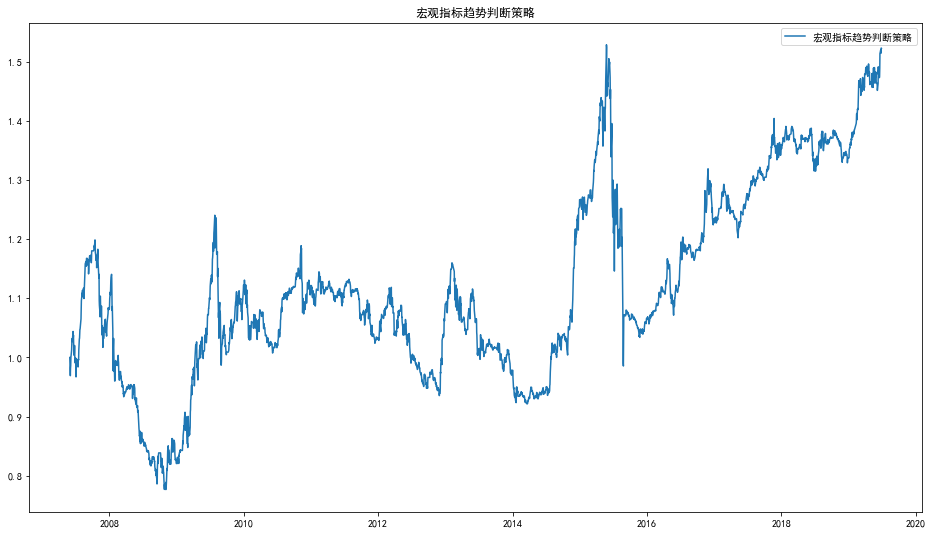

In [194]:
plt.figure(figsize=(16,9))
plt.title(index)
plt.plot(AllDataStrategyEquity[index],label=index)
plt.legend(loc=0)
plt.show()

In [195]:
Indicator(AllDataStrategyEquityIndex)[0].T

,mean_return,vol_return,IR,sharpe_ratio,max_drawdown,mean_return_max_drawdown_ratio
宏观指标趋势判断策略,0.047015,0.147613,0.318505,0.115271,0.355395,0.132291


In [192]:
Indicator(AllDataStrategyEquityIndex)[2]

,宏观指标趋势判断策略
date,
2007-12-31,0.084503
2008-12-31,-0.220077
2009-12-31,0.291156
2010-12-31,-0.045894
2011-12-31,0.012780
2012-12-31,0.057134
2013-12-31,-0.054895
2014-12-31,0.310824
2015-12-31,-0.141626


In [ ]:
'''
4.1 信号是增量数值
'''

In [220]:
MacroDataStrategySignal = pd.DataFrame(index = MacroData_M_Lag1_Return.index)
MacroDataStrategySignal['PMI'] = MacroData_M_Lag1_Return['PMI'].rolling(3).mean().pct_change().dropna()
MacroDataStrategySignal['CPI:当月同比'] = MacroData_M_Lag1_Return['CPI:当月同比'].rolling(9).mean().pct_change()
MacroDataStrategySignal = MacroDataStrategySignal.dropna()

In [221]:
StrategyDateList = MacroDataStrategySignal.index.tolist()

In [229]:
AllDataStrategyEquity = pd.DataFrame()
for index in ['宏观指标趋势判断策略']:
    AllDataStrategyEquityIndex = pd.DataFrame()
    index = index
    tol_equity = 1
    for StrategyDateCnt in range(len(StrategyDateList)-1):

        StrategyDate = StrategyDateList[StrategyDateCnt]
        NextStrategyDate = StrategyDateList[StrategyDateCnt+1]

        PMIsignal = MacroDataStrategySignal.loc[StrategyDate,'PMI']
        CPIsignal = MacroDataStrategySignal.loc[StrategyDate,'CPI:当月同比']

        if PMIsignal >= 0:
            PMIposition = [0.8,0.2,0,0]
        else:
            PMIposition = [0,0,0.8,0.2]

        if CPIsignal >= 0:
            CPIposition = [0,0.8,0,0.2]
        else:
            CPIposition = [0.8,0,0.2,0]

        tol_position_list = []
        K_ = np.abs((PMIsignal+0.00001)/(CPIsignal+0.00001))
        K = K_/(1+K_)
        for i in range(len(AssetList)):
            tol_position_list.append(PMIposition[i]*K+CPIposition[i]*(1-K))

        AllDataReturnSub = AssetReturn[(AssetReturn.index>StrategyDate) & (AssetReturn.index<=NextStrategyDate)].copy()
        AllDataReturnSub = AllDataReturnSub+1
        AllDataReturnSub = AllDataReturnSub[AssetList].copy()
        # 股票 商品 债券 货币
        AllDataReturnSub.iloc[0,:] = [i*tol_equity for i in tol_position_list]
        AllDataReturnSubEquity = AllDataReturnSub.cumprod().sum(axis=1).to_frame(index)
        tol_equity = AllDataReturnSubEquity.iloc[-1,0]
        AllDataStrategyEquityIndex = pd.concat([AllDataStrategyEquityIndex,AllDataReturnSubEquity],axis=0)
    AllDataStrategyEquity = pd.concat([AllDataStrategyEquity,AllDataStrategyEquityIndex],axis=1)

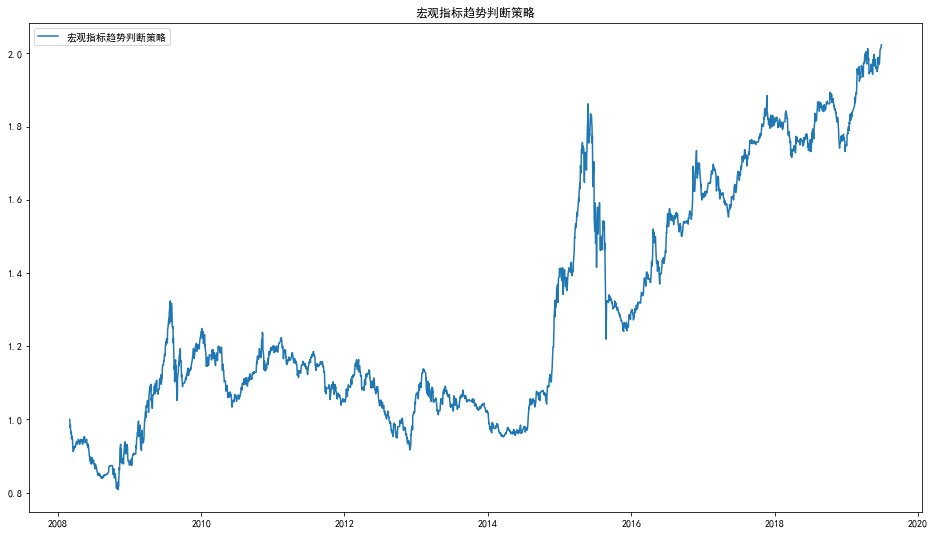

In [230]:
plt.figure(figsize=(16,9))
plt.title(index)
plt.plot(AllDataStrategyEquity[index],label=index)
plt.legend(loc=0)
plt.show()

In [231]:
Indicator(AllDataStrategyEquityIndex)[0].T

,mean_return,vol_return,IR,sharpe_ratio,max_drawdown,mean_return_max_drawdown_ratio
宏观指标趋势判断策略,0.076601,0.15569,0.492009,0.299319,0.345179,0.221917


In [232]:
Indicator(AllDataStrategyEquityIndex)[2]

,宏观指标趋势判断策略
date,
2008-12-31,-0.124493
2009-12-31,0.416077
2010-12-31,-0.031804
2011-12-31,-0.123463
2012-12-31,0.017357
2013-12-31,-0.048433
2014-12-31,0.386605
2015-12-31,-0.083042
2016-12-31,0.240263


In [237]:
AssetReturn[List]

,沪深300,南华商品指数,货币基金,中证全债
date,,,,
2005-01-05,0.009941,-0.005088,0.000091,0.001906
2005-01-06,-0.009460,0.007775,0.000092,0.001602
2005-01-07,0.000797,0.003644,0.000084,0.000200
2005-01-10,0.010083,-0.003138,0.000233,0.000400
2005-01-11,0.003276,0.004985,0.000082,0.000200
2005-01-12,-0.000388,0.005138,0.000095,-0.000200
2005-01-13,0.000129,-0.001052,0.000101,0.000999
2005-01-14,-0.008598,-0.000854,0.000090,0.000499
2005-01-17,-0.021101,-0.000325,0.000244,0.001097


In [236]:
List = ['沪深300','南华商品指数','货币基金','中证全债']